## Language Prediction Based On Names

In [90]:
from io import open
import glob
import os
print(glob.glob('datasets/data/names/*.txt'))

['datasets/data/names\\Arabic.txt', 'datasets/data/names\\Chinese.txt', 'datasets/data/names\\Czech.txt', 'datasets/data/names\\Dutch.txt', 'datasets/data/names\\English.txt', 'datasets/data/names\\French.txt', 'datasets/data/names\\German.txt', 'datasets/data/names\\Greek.txt', 'datasets/data/names\\Irish.txt', 'datasets/data/names\\Italian.txt', 'datasets/data/names\\Japanese.txt', 'datasets/data/names\\Korean.txt', 'datasets/data/names\\Polish.txt', 'datasets/data/names\\Portuguese.txt', 'datasets/data/names\\Russian.txt', 'datasets/data/names\\Scottish.txt', 'datasets/data/names\\Spanish.txt', 'datasets/data/names\\Vietnamese.txt']


In [91]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [92]:
n_letters

57

In [93]:
 # Build the language_names dictionary, a list of names per language
language_names = {}
all_languages = []  

In [94]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [95]:
print(unicodeToAscii('Émile'))

Emile


In [96]:
def findFiles(path): 
    return glob.glob(path)

In [97]:
total_names = 0

for filename in findFiles('datasets/data/names/*.txt'):
    
    language = os.path.splitext(os.path.basename(filename))[0]
    
    all_languages.append(language)
    
    read_names = open(filename, encoding='utf-8').read().strip().split('\n')
    
    names = [unicodeToAscii(line) for line in read_names]
    
    language_names[language] = names
    
    total_names += len(names)

In [98]:
language_names.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [99]:
language_names['Spanish'][100:105]

['Espinosa', 'Espinoza', 'Estevez', 'Etxebarria', 'Etxeberria']

In [100]:
import torch

In [101]:
def letterToTensor(letter):
    
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    
    return tensor

In [102]:
print(letterToTensor('e'))

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [103]:
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    
    for li, letter in enumerate(name):
        tensor[li][0][all_letters.find(letter)] = 1
    
    return tensor

In [104]:
nameToTensor('Est')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [105]:
nameToTensor('Est').shape

torch.Size([3, 1, 57])

In [106]:
nameToTensor('Est').size()

torch.Size([3, 1, 57])

## Design the network

In [108]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
# input 2 hidden > [current + input previus , hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) 
# input 2 output > [current + input previus , output]        
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [113]:
n_hidden = 256
n_languages = len(all_languages)
rnn = RNN(n_letters, n_hidden, n_languages)

In [151]:
#### Manually testing the network

inp = letterToTensor('Car')
inp.shape

torch.Size([1, 57])

In [152]:
hidden = torch.zeros(1, n_hidden)
hidden.shape

torch.Size([1, 256])

In [153]:
output, next_hidden = rnn(inp, hidden)

In [154]:
hidden

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [155]:
output

tensor([[-2.8870, -2.9216, -2.9177, -2.8538, -2.8779, -2.9389, -2.8453, -2.8779,
         -2.8443, -2.9169, -2.9111, -2.9028, -2.8058, -2.8975, -2.9242, -2.9375,
         -2.8423, -2.9376]], grad_fn=<LogSoftmaxBackward>)

In [156]:
print('output size =', output.size())
print('next_hidden size =', next_hidden.size())

output size = torch.Size([1, 18])
next_hidden size = torch.Size([1, 256])


In [158]:
output


tensor([[-2.8870, -2.9216, -2.9177, -2.8538, -2.8779, -2.9389, -2.8453, -2.8779,
         -2.8443, -2.9169, -2.9111, -2.9028, -2.8058, -2.8975, -2.9242, -2.9375,
         -2.8423, -2.9376]], grad_fn=<LogSoftmaxBackward>)

In [163]:
print(next_hidden.shape)

torch.Size([1, 256])


In [165]:
output.topk(3)

torch.return_types.topk(
values=tensor([[-2.8058, -2.8423, -2.8443]], grad_fn=<TopkBackward>),
indices=tensor([[12, 16,  8]]))

In [167]:
def languageFromOutput(output):
    
    _, top_i = output.topk(1)
    
    language_i = top_i[0].item()
    
    return all_languages[language_i], language_i

In [169]:
print(languageFromOutput(output))

('Polish', 12)


### random train 

In [172]:
import random

def randomTrainingExample():
    
    random_language_index = random.randint(0, n_languages - 1)
    language = all_languages[random_language_index]
    
    random_language_names = language_names[language]
    
    name = random_language_names[random.randint(0, len(random_language_names) - 1)]
    
    language_tensor = torch.tensor([all_languages.index(language)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    
    return language, name, language_tensor, name_tensor

In [178]:
for i in range(10):
    language, name, language_tensor, name_tensor = randomTrainingExample()
    
    print('language =', language, ', name =', name, '   language_tensor =', language_tensor)

language = Scottish , name = Hunter    language_tensor = tensor([15])
language = Dutch , name = Houttum    language_tensor = tensor([3])
language = German , name = Mendelssohn    language_tensor = tensor([6])
language = Italian , name = Fausti    language_tensor = tensor([9])
language = Czech , name = Coma    language_tensor = tensor([2])
language = Italian , name = Fonda    language_tensor = tensor([9])
language = Italian , name = Vescovi    language_tensor = tensor([9])
language = Italian , name = Carbone    language_tensor = tensor([9])
language = Spanish , name = Gonzalez    language_tensor = tensor([16])
language = Italian , name = Laconi    language_tensor = tensor([9])


#### Training the Network

In [86]:
criterion = nn.NLLLoss()
learning_rate = 0.005 

In [189]:
def train(langauge_tensor, name_tensor):
    
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, langauge_tensor)
    loss.backward()

# writen optimizer     
    for p in rnn.parameters():
#         print ('rnn.parameters: ', (rnn.parameters())
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [201]:
n_iters = 20000

current_loss = 0
all_losses = []

In [202]:
for epoch in range(1, n_iters + 1):
    
    language, name, language_tensor, name_tensor = randomTrainingExample()
    
    output, loss = train(language_tensor, name_tensor)
    current_loss += loss

    if epoch % 100 == 0:
        guess, guess_i = languageFromOutput(output)
        correct = '✓' if guess == language else '✗ (%s)' % language
        
        print('%d %d%% %.4f %s / %s %s' % (epoch, 
                                           epoch / n_iters * 100,
                                           loss,
                                           name, 
                                           guess, 
                                           correct))

    if epoch % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

100 0% 1.5465 Esteves / Portuguese ✓
200 1% 1.5746 Delaney / Irish ✓
300 1% 3.5859 Petit / French ✗ (Spanish)
400 2% 2.2289 Fuentes / Portuguese ✗ (Spanish)
500 2% 1.1333 Alexander / Scottish ✓
600 3% 2.9170 Friedrich / Irish ✗ (Czech)
700 3% 0.1807 Albuquerque / Portuguese ✓
800 4% 0.4635 Mifsud / Arabic ✓
900 4% 3.8994 Beer / German ✗ (English)
1000 5% 0.8931 Mayer / German ✓
1100 5% 0.5899 Rutten / Dutch ✓
1200 6% 1.5595 Chung / Korean ✗ (Vietnamese)
1300 6% 0.3255 Lemieux / French ✓
1400 7% 1.1861 Vennen / German ✗ (Dutch)
1500 7% 0.0314 Mcdonald / Scottish ✓
1600 8% 1.7866 Karl / German ✗ (Dutch)
1700 8% 0.3980 Deulenko / Russian ✓
1800 9% 0.2689 Thi / Vietnamese ✓
1900 9% 0.2077 Kefalas / Greek ✓
2000 10% 0.3241 Nevin / Irish ✓
2100 10% 0.1096 Agnelli / Italian ✓
2200 11% 2.4972 Seif / Chinese ✗ (Arabic)
2300 11% 1.7057 Dounias / Portuguese ✗ (Greek)
2400 12% 1.1986 Matsushina / Japanese ✓
2500 12% 0.8931 Honjas / Greek ✓
2600 13% 0.3418 Gorecki / Polish ✓
2700 13% 0.8557 Avana /

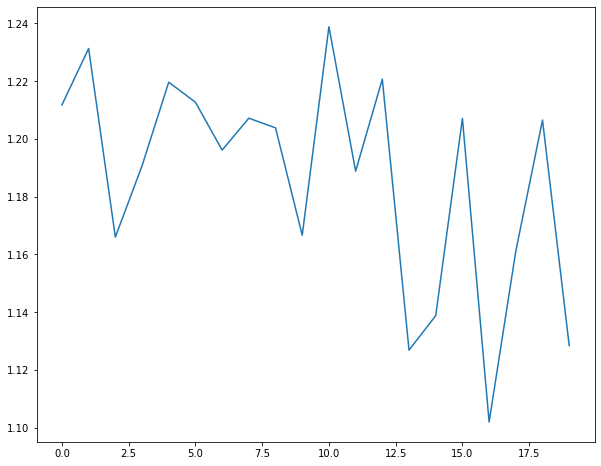

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(all_losses)
plt.show()

#### Running on User Input

In [204]:
n_predictions = 3

In [237]:
input_name = 'ONeill' #Re-run for 'Amaya' and 'Bukoski'

In [238]:
with torch.no_grad():
    
    name_tensor = nameToTensor(input_name)
    
    hidden = rnn.initHidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    topv, topi = output.topk(n_predictions, 1, True)

    for i in range(n_predictions):
        
        value = topv[0][i].item()
        language_index = topi[0][i].item()
        
        print('(%.2f) %s' % (value, all_languages[language_index]))

(-0.15) Irish
(-3.34) English
(-3.47) Spanish
